# Monte Carlo - Doble Pozo


\begin{equation}
V(x)=E_{0}\left[ \left(\frac{x}{a}\right)^4 -2\left(\frac{x}{a}\right)^2 \right]-\frac{b}{a}x
\end{equation}

In [1]:
import openmm as mm
from openmm import app
from openmm import unit
from openmmtools.constants import kB
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from numpy.random import default_rng
rng = default_rng()

In [3]:
# Definición del sistema.

n_particles = 1
mass = 100 * unit.amu

In [4]:
# Creación del sistema.

system = mm.System()

for ii in range(n_particles):
    system.addParticle(mass)

In [5]:
# Añadiendo el potencial externo al sistema

Eo = 3.0 * unit.kilocalories_per_mole
a = 0.5 * unit.nanometers
b = 0.0 * unit.kilocalories_per_mole
k = 1.0*unit.kilocalories_per_mole/unit.angstrom**2

A = Eo/(a**4)
B = -2.0*Eo/(a**2)
C = -b/a
D = k/2.0

force = mm.CustomExternalForce('A*x^4+B*x^2+C*x + D*(y^2+z^2)')
force.addGlobalParameter('A', A)
force.addGlobalParameter('B', B)
force.addGlobalParameter('C', C)
force.addGlobalParameter('D', D)


for ii in range(n_particles):
    force.addParticle(ii, [])

_ = system.addForce(force)


In [6]:
# Definición del estado termodinámico y el integrador.

step_size = 0.01*unit.picoseconds
temperature = 300*unit.kelvin
friction = 1.0/unit.picosecond # Damping para la dinámica de Langevin

integrator = mm.LangevinIntegrator(temperature, friction, step_size)

**Por favor prueba a remplazar en la siguiente celda 'CPU' por 'CUDA' a ver si corre**

In [7]:
# Creación de la plataforma.

platform_name = 'CUDA'
platform = mm.Platform.getPlatformByName(platform_name)

In [8]:
# Creación del contexto.
context = mm.Context(system, integrator, platform)

In [9]:
def movement(lmax):
    return lmax * rng.uniform(-1,1)

In [10]:
def decide(Ui, Uf, temperature):
    
    kBT = kB * temperature
    
    accept = False

    if Uf <= Ui:
        accept = True
    else:
        weight = np.exp(- (Uf - Ui)/kBT)
        random = rng.uniform(0,1)
        if weight >= random:
            accept = True
        else:
            accept = False
            
    return accept

In [23]:
# Condiciones iniciales

initial_positions  = np.zeros([n_particles, 3], np.float32) * unit.angstroms
initial_positions[0,0] = 5.0 * unit.angstroms

mc_steps = 50000
num_trues = 0

mc_traj = np.zeros([mc_steps+1], np.float32) * unit.angstroms
mc_traj[0] = initial_positions[0,0]

for ii in tqdm(range(mc_steps)):

    context.setPositions(initial_positions)
    state_initial = context.getState(getEnergy=True)
    Ui = state_initial.getPotentialEnergy()
    
    final_positions = np.zeros([n_particles, 3], np.float32) * unit.angstroms
    final_positions[0,0] = initial_positions[0,0] + movement(4.0*unit.angstroms)
    context.setPositions(final_positions)
    state_final = context.getState(getEnergy=True)
    Uf = state_final.getPotentialEnergy()
    
    accept = decide(Ui, Uf, temperature)
    
    if accept == True:
        initial_positions = final_positions
        num_trues += 1

    mc_traj[ii+1] = initial_positions[0,0]
        
acceptance_rate=num_trues/mc_steps

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:16<00:00, 3019.51it/s]


In [24]:
acceptance_rate

0.34022

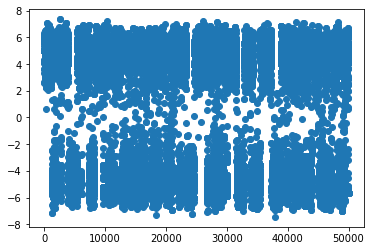

In [25]:
plt.scatter(range(mc_steps+1), mc_traj)

In [26]:
mc_traj.mean()

Quantity(value=0.705989, unit=angstrom)